#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 **'subject' 칼럼은 불필요** 하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [6]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [7]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [8]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [9]:
#전체 데이터의 상위 5개 행 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [10]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [11]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [12]:
target = 'Activity'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [13]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [14]:
# 정수 인코딩 변환
int_Encoder = LabelEncoder()
y = int_Encoder.fit_transform(y)

In [15]:
# 기존 레이블 저장
y_labels = int_Encoder.classes_
y_labels

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [16]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 100)

### (5) 파이토치 자료형 변환

* 세부 요구사항
    - 각 데이터를 torch.tensor( )로 변환합니다.
    - tensor로 변환한 데이터를 TensorDataset( )으로 데이터셋화 합니다.
    - 데이터셋을 배치 단위로 불러올 수 있게 DataLoader( )를 사용합니다.

In [17]:
x_tr_tensor = torch.tensor(x_train, dtype=torch.float32)
y_tr_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [18]:
dataset_train = TensorDataset(x_tr_tensor, y_tr_tensor)
dataset_valid = TensorDataset(x_val_tensor, y_val_tensor)

In [19]:
dataloader_train = DataLoader(dataset_train, batch_size=32)
dataloader_valid = DataLoader(dataset_valid, batch_size=32)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1

In [20]:
n_features = x_train.shape[1]

In [21]:
# 모델 구조 설계

class ModelOne(nn.Module) :
    def __init__(self, n_features) :
        super(ModelOne, self).__init__()
        self.fc = nn.Linear(n_features, 6)

    def forward(self, x) :
        return self.fc(x)

In [22]:
# 0. 반복 결과 저장용 DataFrame 준비
results_df = pd.DataFrame(columns=['Model', 'Trial', 'Accuracy'])

# 1. 반복 수행 루프 시작
n_trials = 5
for trial in range(n_trials):

    # 1-1. 모델/옵티마이저/손실함수 초기화
    model1 = ModelOne(n_features)
    optimizer = Adam(model1.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    history = {'loss': [], 'val_loss': []}

    # 1-2. 모델 학습/검증
    # 모델 학습
    for epoch in range(50) :
      model1.train()
      train_loss = 0

      for x_batch, y_batch in dataloader_train :
          optimizer.zero_grad()
          output = model1(x_batch)
          loss = criterion(output, y_batch)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      avg_train_loss = train_loss / len(dataloader_train)

      # 모델 검증
      model1.eval()
      val_loss = 0
      with torch.no_grad() :
          for x_batch, y_batch in dataloader_valid :
              output = model1(x_batch)
              loss = criterion(output, y_batch)
              val_loss += loss.item()
      avg_val_loss = val_loss / len(dataloader_valid)

      history['loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)

      print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # 1-3. 예측 및 평가
    with torch.no_grad() :
      pred_logits = model1(x_val_tensor)
      predictions = torch.argmax(pred_logits, dim=1)

      acc = accuracy_score(y_val, predictions.numpy())  # 데이터프레임 추가 위해 정확도 저장

    print('Accuracy:', accuracy_score(y_val, predictions.numpy()))
    print('='*60)
    print(confusion_matrix(y_val, predictions.numpy()))
    print('='*60)
    print(classification_report(y_val, predictions.numpy(), target_names=y_labels) )

    # 1-4. 결과 저장
    new_row = pd.DataFrame([{'Model': 'Model 1', 'Trial': trial+1, 'Accuracy': acc}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# 2. 결과 평균 출력
print(results_df.groupby('Model')['Accuracy'].mean())

Epoch 1 | Train Loss: 1.0252, Val Loss: 0.7558
Epoch 2 | Train Loss: 0.6398, Val Loss: 0.5600
Epoch 3 | Train Loss: 0.4986, Val Loss: 0.4575
Epoch 4 | Train Loss: 0.4181, Val Loss: 0.3935
Epoch 5 | Train Loss: 0.3650, Val Loss: 0.3493
Epoch 6 | Train Loss: 0.3268, Val Loss: 0.3164
Epoch 7 | Train Loss: 0.2977, Val Loss: 0.2909
Epoch 8 | Train Loss: 0.2744, Val Loss: 0.2702
Epoch 9 | Train Loss: 0.2554, Val Loss: 0.2531
Epoch 10 | Train Loss: 0.2393, Val Loss: 0.2385
Epoch 11 | Train Loss: 0.2255, Val Loss: 0.2260
Epoch 12 | Train Loss: 0.2135, Val Loss: 0.2150
Epoch 13 | Train Loss: 0.2030, Val Loss: 0.2053
Epoch 14 | Train Loss: 0.1935, Val Loss: 0.1966
Epoch 15 | Train Loss: 0.1851, Val Loss: 0.1888
Epoch 16 | Train Loss: 0.1774, Val Loss: 0.1817
Epoch 17 | Train Loss: 0.1704, Val Loss: 0.1752
Epoch 18 | Train Loss: 0.1640, Val Loss: 0.1693
Epoch 19 | Train Loss: 0.1581, Val Loss: 0.1639
Epoch 20 | Train Loss: 0.1527, Val Loss: 0.1589
Epoch 21 | Train Loss: 0.1477, Val Loss: 0.1543
E

<ipython-input-22-72aee5fe93b3>:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Epoch 2 | Train Loss: 0.6450, Val Loss: 0.5640
Epoch 3 | Train Loss: 0.5014, Val Loss: 0.4598
Epoch 4 | Train Loss: 0.4197, Val Loss: 0.3950
Epoch 5 | Train Loss: 0.3661, Val Loss: 0.3503
Epoch 6 | Train Loss: 0.3276, Val Loss: 0.3172
Epoch 7 | Train Loss: 0.2983, Val Loss: 0.2915
Epoch 8 | Train Loss: 0.2749, Val Loss: 0.2708
Epoch 9 | Train Loss: 0.2558, Val Loss: 0.2536
Epoch 10 | Train Loss: 0.2397, Val Loss: 0.2390
Epoch 11 | Train Loss: 0.2259, Val Loss: 0.2264
Epoch 12 | Train Loss: 0.2138, Val Loss: 0.2154
Epoch 13 | Train Loss: 0.2032, Val Loss: 0.2056
Epoch 14 | Train Loss: 0.1938, Val Loss: 0.1969
Epoch 15 | Train Loss: 0.1853, Val Loss: 0.1891
Epoch 16 | Train Loss: 0.1776, Val Loss: 0.1820
Epoch 17 | Train Loss: 0.1706, Val Loss: 0.1755
Epoch 18 | Train Loss: 0.1642, Val Loss: 0.1696
Epoch 19 | Train Loss: 0.1583, Val Loss: 0.1642
Epoch 20 | Train Loss: 0.1529, Val Loss: 0.1592
Epoch 21 | Train Loss: 0.1479, Val Loss: 0.1545
Epoch 22 | Train Loss: 0.1432, Val Loss: 0.1502


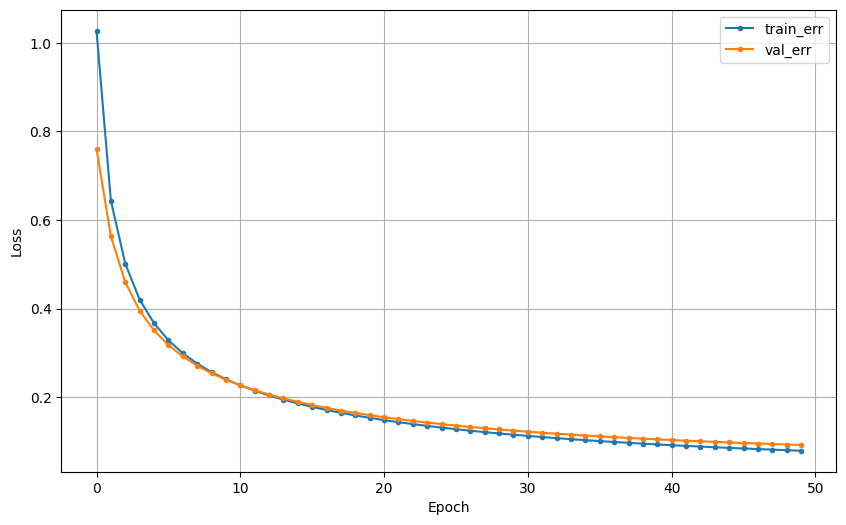

In [23]:
# 학습곡선
dl_history_plot(history)

### (2) 모델2

In [24]:
n_features = x_train.shape[1]

In [25]:
# 모델 구조 설계

class ModelTwo(nn.Module) :
    def __init__(self, n_features) :
        super(ModelTwo, self).__init__()

        self.fc1 = nn.Linear(n_features, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(64, 32)
        self.fc10 = nn.Linear(32, 32)
        self.fc11 = nn.Linear(32, 6)

    def forward(self, x) :
        x = F.relu(self.fc1(x) )
        x = F.relu(self.fc2(x) )
        x = F.relu(self.fc3(x) )
        x = F.relu(self.fc4(x) )
        x = F.relu(self.fc5(x) )
        x = F.relu(self.fc6(x) )
        x = F.relu(self.fc7(x) )
        x = F.relu(self.fc8(x) )
        x = F.relu(self.fc9(x) )
        x = F.relu(self.fc10(x) )
        x = self.fc11(x)
        return x

In [26]:
# 1. 반복 수행 루프 시작
n_trials = 5
for trial in range(n_trials):

    # 1-1. 모델/옵티마이저/손실함수 초기화
    model2 = ModelTwo(n_features)
    optimizer = Adam(model2.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    history = {'loss': [], 'val_loss': []}

    # 1-2. 모델 학습/검증
    # 모델 학습
    for epoch in range(50) :
      model2.train()
      train_loss = 0

      for x_batch, y_batch in dataloader_train :
          optimizer.zero_grad()
          output = model2(x_batch)
          loss = criterion(output, y_batch)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      avg_train_loss = train_loss / len(dataloader_train)

      # 모델 검증
      model2.eval()
      val_loss = 0
      with torch.no_grad() :
          for x_batch, y_batch in dataloader_valid :
              output = model2(x_batch)
              loss = criterion(output, y_batch)
              val_loss += loss.item()
      avg_val_loss = val_loss / len(dataloader_valid)

      history['loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)

      print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # 1-3. 예측 및 평가
    with torch.no_grad() :
      pred_logits = model2(x_val_tensor)
      predictions = torch.argmax(pred_logits, dim=1)

      acc = accuracy_score(y_val, predictions.numpy())  # 데이터프레임 추가 위해 정확도 저장

    print('Accuracy:', accuracy_score(y_val, predictions.numpy()))
    print('='*60)
    print(confusion_matrix(y_val, predictions.numpy()))
    print('='*60)
    print(classification_report(y_val, predictions.numpy(), target_names=y_labels) )

    # 1-4. 결과 저장
    new_row = pd.DataFrame([{'Model': 'Model 2', 'Trial': trial+1, 'Accuracy': acc}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# 2. 결과 평균 출력
print(results_df.groupby('Model')['Accuracy'].mean())

Epoch 1 | Train Loss: 1.2340, Val Loss: 1.1167
Epoch 2 | Train Loss: 1.0076, Val Loss: 0.8467
Epoch 3 | Train Loss: 0.7726, Val Loss: 0.7421
Epoch 4 | Train Loss: 0.6603, Val Loss: 0.6495
Epoch 5 | Train Loss: 0.6431, Val Loss: 0.6000
Epoch 6 | Train Loss: 0.6379, Val Loss: 0.6484
Epoch 7 | Train Loss: 0.5100, Val Loss: 0.4200
Epoch 8 | Train Loss: 0.4940, Val Loss: 0.4984
Epoch 9 | Train Loss: 0.3551, Val Loss: 0.4091
Epoch 10 | Train Loss: 0.3028, Val Loss: 0.4359
Epoch 11 | Train Loss: 0.2148, Val Loss: 0.2565
Epoch 12 | Train Loss: 0.1601, Val Loss: 0.1813
Epoch 13 | Train Loss: 0.1311, Val Loss: 0.2623
Epoch 14 | Train Loss: 0.1216, Val Loss: 0.1775
Epoch 15 | Train Loss: 0.1102, Val Loss: 0.1313
Epoch 16 | Train Loss: 0.0818, Val Loss: 0.1284
Epoch 17 | Train Loss: 0.0721, Val Loss: 0.1167
Epoch 18 | Train Loss: 0.0897, Val Loss: 0.1190
Epoch 19 | Train Loss: 0.0632, Val Loss: 0.0996
Epoch 20 | Train Loss: 0.0662, Val Loss: 0.1393
Epoch 21 | Train Loss: 0.0696, Val Loss: 0.2627
E

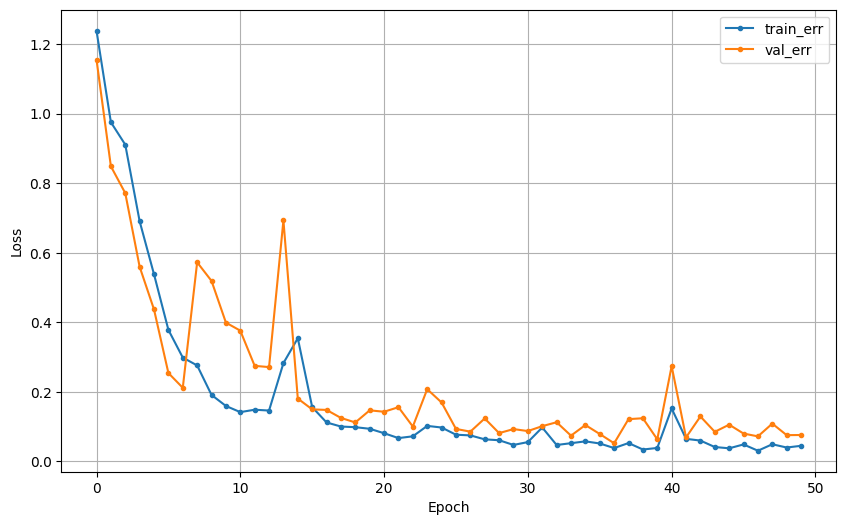

In [27]:
# 학습곡선
dl_history_plot(history)

### (3) 모델3

In [28]:
n_features = x_train.shape[1]

In [29]:
# 모델 구조 설계
do_rate = 0.1

class ModelThree(nn.Module) :
    def __init__(self, n_features) :
        super(ModelThree, self).__init__()

        self.fc1 = nn.Linear(n_features, 512)
        self.dropout1 = nn.Dropout(do_rate)
        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(do_rate)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(do_rate)
        self.fc4 = nn.Linear(256, 256)
        self.dropout4 = nn.Dropout(do_rate)
        self.fc5 = nn.Linear(256, 128)
        self.dropout5 = nn.Dropout(do_rate)
        self.fc6 = nn.Linear(128, 128)
        self.dropout6 = nn.Dropout(do_rate)
        self.fc7 = nn.Linear(128, 64)
        self.dropout7 = nn.Dropout(do_rate)
        self.fc8 = nn.Linear(64, 64)
        self.dropout8 = nn.Dropout(do_rate)
        self.fc9 = nn.Linear(64, 32)
        self.dropout9 = nn.Dropout(do_rate)
        self.fc10 = nn.Linear(32, 32)
        self.dropout10 = nn.Dropout(do_rate)
        self.fc11 = nn.Linear(32, 6)

    def forward(self, x) :
        x = F.relu(self.fc1(x) )
        x = self.dropout1(x)
        x = F.relu(self.fc2(x) )
        x = self.dropout2(x)
        x = F.relu(self.fc3(x) )
        x = self.dropout3(x)
        x = F.relu(self.fc4(x) )
        x = self.dropout4(x)
        x = F.relu(self.fc5(x) )
        x = self.dropout5(x)
        x = F.relu(self.fc6(x) )
        x = self.dropout6(x)
        x = F.relu(self.fc7(x) )
        x = self.dropout7(x)
        x = F.relu(self.fc8(x) )
        x = self.dropout8(x)
        x = F.relu(self.fc9(x) )
        x = self.dropout9(x)
        x = F.relu(self.fc10(x) )
        x = self.dropout10(x)
        x = self.fc11(x)
        return x

In [30]:
# 1. 반복 수행 루프 시작
n_trials = 5
for trial in range(n_trials):

    # 1-1. 모델/옵티마이저/손실함수 초기화
    model3 = ModelThree(n_features)
    optimizer = Adam(model3.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    history = {'loss': [], 'val_loss': []}

    # 1-2. 모델 학습/검증
    # 모델 학습
    for epoch in range(50) :
      model3.train()
      train_loss = 0

      for x_batch, y_batch in dataloader_train :
          optimizer.zero_grad()
          output = model3(x_batch)
          loss = criterion(output, y_batch)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      avg_train_loss = train_loss / len(dataloader_train)

      # 모델 검증
      model3.eval()
      val_loss = 0
      with torch.no_grad() :
          for x_batch, y_batch in dataloader_valid :
              output = model3(x_batch)
              loss = criterion(output, y_batch)
              val_loss += loss.item()
      avg_val_loss = val_loss / len(dataloader_valid)

      history['loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)

      print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # 1-3. 예측 및 평가
    with torch.no_grad() :
      pred_logits = model3(x_val_tensor)
      predictions = torch.argmax(pred_logits, dim=1)

      acc = accuracy_score(y_val, predictions.numpy())  # 데이터프레임 추가 위해 정확도 저장

    print('Accuracy:', accuracy_score(y_val, predictions.numpy()))
    print('='*60)
    print(confusion_matrix(y_val, predictions.numpy()))
    print('='*60)
    print(classification_report(y_val, predictions.numpy(), target_names=y_labels) )

    # 1-4. 결과 저장
    new_row = pd.DataFrame([{'Model': 'Model 3', 'Trial': trial+1, 'Accuracy': acc}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# 2. 결과 평균 출력
print(results_df.groupby('Model')['Accuracy'].mean())

Epoch 1 | Train Loss: 1.3301, Val Loss: 1.1204
Epoch 2 | Train Loss: 1.1327, Val Loss: 1.0286
Epoch 3 | Train Loss: 0.9448, Val Loss: 0.8243
Epoch 4 | Train Loss: 0.7842, Val Loss: 0.6454
Epoch 5 | Train Loss: 0.6343, Val Loss: 0.5612
Epoch 6 | Train Loss: 0.5725, Val Loss: 0.5612
Epoch 7 | Train Loss: 0.4799, Val Loss: 0.4834
Epoch 8 | Train Loss: 0.4735, Val Loss: 0.4329
Epoch 9 | Train Loss: 0.4138, Val Loss: 0.3681
Epoch 10 | Train Loss: 0.3553, Val Loss: 0.3150
Epoch 11 | Train Loss: 0.3503, Val Loss: 0.6045
Epoch 12 | Train Loss: 0.4238, Val Loss: 0.3467
Epoch 13 | Train Loss: 0.3211, Val Loss: 0.2939
Epoch 14 | Train Loss: 0.2942, Val Loss: 0.3303
Epoch 15 | Train Loss: 0.3001, Val Loss: 0.2283
Epoch 16 | Train Loss: 0.1945, Val Loss: 0.2352
Epoch 17 | Train Loss: 0.2483, Val Loss: 0.2797
Epoch 18 | Train Loss: 0.2004, Val Loss: 0.2254
Epoch 19 | Train Loss: 0.2001, Val Loss: 0.2092
Epoch 20 | Train Loss: 0.2189, Val Loss: 0.2275
Epoch 21 | Train Loss: 0.1598, Val Loss: 0.2294
E

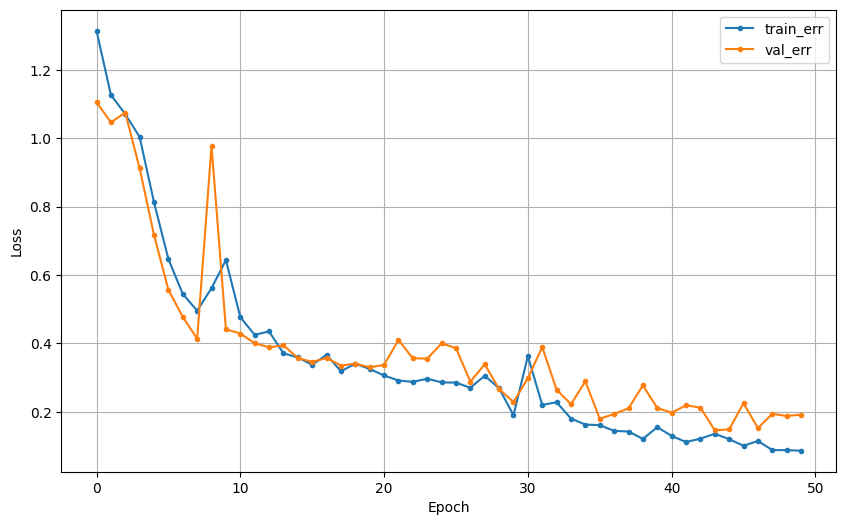

In [31]:
# 학습곡선
dl_history_plot(history)

### (4) 모델4

In [32]:
n_features = x_train.shape[1]

In [33]:
# 모델 구조 설계
do_rate = 0.2

class ModelFour(nn.Module) :
    def __init__(self, n_features) :
        super(ModelFour, self).__init__()

        self.fc1 = nn.Linear(n_features, 512)
        self.dropout1 = nn.Dropout(do_rate)
        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(do_rate)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(do_rate)
        self.fc4 = nn.Linear(256, 256)
        self.dropout4 = nn.Dropout(do_rate)
        self.fc5 = nn.Linear(256, 128)
        self.dropout5 = nn.Dropout(do_rate)
        self.fc6 = nn.Linear(128, 128)
        self.dropout6 = nn.Dropout(do_rate)
        self.fc7 = nn.Linear(128, 64)
        self.dropout7 = nn.Dropout(do_rate)
        self.fc8 = nn.Linear(64, 64)
        self.dropout8 = nn.Dropout(do_rate)
        self.fc9 = nn.Linear(64, 32)
        self.dropout9 = nn.Dropout(do_rate)
        self.fc10 = nn.Linear(32, 32)
        self.dropout10 = nn.Dropout(do_rate)
        self.fc11 = nn.Linear(32, 6)

    def forward(self, x) :
        x = F.relu(self.fc1(x) )
        x = self.dropout1(x)
        x = F.relu(self.fc2(x) )
        x = self.dropout2(x)
        x = F.relu(self.fc3(x) )
        x = self.dropout3(x)
        x = F.relu(self.fc4(x) )
        x = self.dropout4(x)
        x = F.relu(self.fc5(x) )
        x = self.dropout5(x)
        x = F.relu(self.fc6(x) )
        x = self.dropout6(x)
        x = F.relu(self.fc7(x) )
        x = self.dropout7(x)
        x = F.relu(self.fc8(x) )
        x = self.dropout8(x)
        x = F.relu(self.fc9(x) )
        x = self.dropout9(x)
        x = F.relu(self.fc10(x) )
        x = self.dropout10(x)
        x = self.fc11(x)
        return x

In [34]:
# 1. 반복 수행 루프 시작
n_trials = 5
for trial in range(n_trials):

    # 1-1. 모델/옵티마이저/손실함수 초기화
    model4 = ModelFour(n_features)
    optimizer = Adam(model4.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    history = {'loss': [], 'val_loss': []}

    # 1-2. 모델 학습/검증
    # 모델 학습
    for epoch in range(50) :
      model4.train()
      train_loss = 0

      for x_batch, y_batch in dataloader_train :
          optimizer.zero_grad()
          output = model4(x_batch)
          loss = criterion(output, y_batch)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      avg_train_loss = train_loss / len(dataloader_train)

      # 모델 검증
      model4.eval()
      val_loss = 0
      with torch.no_grad() :
          for x_batch, y_batch in dataloader_valid :
              output = model4(x_batch)
              loss = criterion(output, y_batch)
              val_loss += loss.item()
      avg_val_loss = val_loss / len(dataloader_valid)

      history['loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)

      print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # 1-3. 예측 및 평가
    with torch.no_grad() :
      pred_logits = model4(x_val_tensor)
      predictions = torch.argmax(pred_logits, dim=1)

      acc = accuracy_score(y_val, predictions.numpy())  # 데이터프레임 추가 위해 정확도 저장

    print('Accuracy:', accuracy_score(y_val, predictions.numpy()))
    print('='*60)
    print(confusion_matrix(y_val, predictions.numpy()))
    print('='*60)
    print(classification_report(y_val, predictions.numpy(), target_names=y_labels) )

    # 1-4. 결과 저장
    new_row = pd.DataFrame([{'Model': 'Model 4', 'Trial': trial+1, 'Accuracy': acc}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# 2. 결과 평균 출력
print(results_df.groupby('Model')['Accuracy'].mean())

Epoch 1 | Train Loss: 1.4103, Val Loss: 1.0122
Epoch 2 | Train Loss: 1.0238, Val Loss: 0.9007
Epoch 3 | Train Loss: 0.8627, Val Loss: 0.7926
Epoch 4 | Train Loss: 0.7704, Val Loss: 0.6590
Epoch 5 | Train Loss: 0.6778, Val Loss: 0.5905
Epoch 6 | Train Loss: 0.6154, Val Loss: 0.5827
Epoch 7 | Train Loss: 0.5849, Val Loss: 0.4990
Epoch 8 | Train Loss: 0.5293, Val Loss: 0.4312
Epoch 9 | Train Loss: 0.5162, Val Loss: 0.4324
Epoch 10 | Train Loss: 0.5078, Val Loss: 0.5285
Epoch 11 | Train Loss: 0.4327, Val Loss: 0.3299
Epoch 12 | Train Loss: 0.3564, Val Loss: 0.2785
Epoch 13 | Train Loss: 0.3751, Val Loss: 0.2935
Epoch 14 | Train Loss: 0.3324, Val Loss: 0.2658
Epoch 15 | Train Loss: 0.3665, Val Loss: 0.3069
Epoch 16 | Train Loss: 0.3108, Val Loss: 0.2648
Epoch 17 | Train Loss: 0.2712, Val Loss: 0.2715
Epoch 18 | Train Loss: 0.2623, Val Loss: 0.2490
Epoch 19 | Train Loss: 0.2262, Val Loss: 0.2352
Epoch 20 | Train Loss: 0.2009, Val Loss: 0.2305
Epoch 21 | Train Loss: 0.2123, Val Loss: 0.3042
E

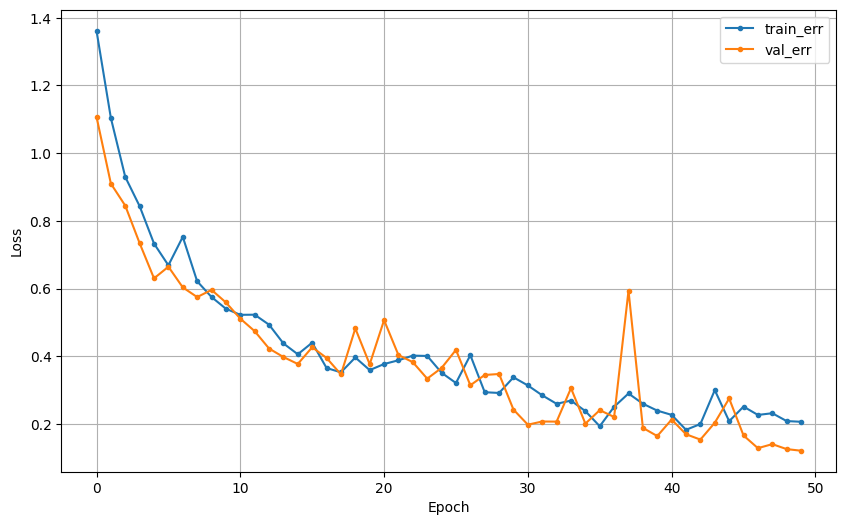

In [35]:
# 학습곡선
dl_history_plot(history)

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [39]:
#전체 데이터 불러오기
file2 = "data01_test.csv"
newdata = pd.read_csv(path+file2)

# subject 삭제
newdata.drop('subject', axis=1, inplace=True)

# x, y 분할
new_x = newdata.drop(['Activity'], axis = 1)
new_y = newdata.Activity

# x : 스케일링 적용
new_x = scaler.transform(new_x)

# y : 정수인코딩 적용
new_y = int_Encoder.transform(new_y)

In [40]:
# new_x, new_y에 대해 파이토치 텐서화
new_x_tensor = torch.tensor(new_x, dtype=torch.float32)
new_y_tensor = torch.tensor(new_y, dtype=torch.long)

In [41]:
models = [model1, model2, model3, model4]

for i, model in enumerate(models) :
    with torch.no_grad() :
        pred_logits = model(new_x_tensor)
        predictions = torch.argmax(pred_logits, dim=1)
    print(f'Model {i+1} Accuracy:', accuracy_score(new_y, predictions.numpy()))

Model 1 Accuracy: 0.9687287559483345
Model 2 Accuracy: 0.9666893269884432
Model 3 Accuracy: 0.9673691366417403
Model 4 Accuracy: 0.95581237253569
